In [1]:
%matplotlib inline

import math
import time
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.layers import LSTM
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from datetime import date, datetime, time, timedelta

print(tf.__version__)

2.9.2


In [2]:
# Colab에서 kaggle 다운로드, kaggle API 업로드
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"eddkang","key":"1a6f4a96f9210e5ef549467b5c2971d4"}'}

In [3]:
# ls -1ha kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Persmisson Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

# kaggle에서 다운로드
!kaggle datasets download -d artemburenok/sp-500-stock-prices

# zip으로 압축되어 있는지 확인하고, 압축 해제
!ls
!unzip sp-500-stock-prices.zip

sp-500-stock-prices.zip: Skipping, found more recently modified local copy (use --force to force download)
 AAL.csv     DAL.csv	 JKHY.csv	    PPL.csv
 AAP.csv     D.csv	 JNJ.csv	    PRU.csv
 AAPL.csv    DD.csv	 JNPR.csv	    PSA.csv
 ABBV.csv    DE.csv	 JPM.csv	    PSX.csv
 ABC.csv     DFS.csv	'kaggle (1).json'   PTC.csv
 ABMD.csv    DG.csv	'kaggle (2).json'   PWR.csv
 ABT.csv     DGX.csv	 kaggle.json	    PXD.csv
 ACGL.csv    DHI.csv	 K.csv		    PYPL.csv
 ACN.csv     DHR.csv	 KDP.csv	    QCOM.csv
 A.csv	     DIS.csv	 KEY.csv	    QRVO.csv
 ADBE.csv    DISH.csv	 KEYS.csv	    RCL.csv
 ADI.csv     DLR.csv	 KHC.csv	    RE.csv
 ADM.csv     DLTR.csv	 KIM.csv	    REG.csv
 ADP.csv     DOV.csv	 KLAC.csv	    REGN.csv
 ADSK.csv    DOW.csv	 KMB.csv	    RF.csv
 AEE.csv     DPZ.csv	 KMI.csv	    RHI.csv
 AEP.csv     DRI.csv	 KMX.csv	    RJF.csv
 AES.csv     DTE.csv	 KO.csv		    RL.csv
 AFL.csv     DUK.csv	 KR.csv		    RMD.csv
 AIG.csv     DVA.csv	 L.csv		    ROK.csv
 AIZ.csv     DVN.csv	 LDOS.csv	    R

In [4]:
def new_dataset(dataset, step_size):
	data_X, data_Y = [], []
	for i in range(len(dataset)-step_size-1):
		a = dataset[i:(i+step_size), 0]
		data_X.append(a)
		data_Y.append(dataset[i + step_size, 0])
	return np.array(data_X), np.array(data_Y)

In [5]:
column_names = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
raw_dataset = pd.read_csv('/content/AAPL.csv', names=column_names,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True)

dataset = raw_dataset.copy()
# dataset, 위에서 부터 5개의 행 출력
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,Date,Open,High,Low,Close,Adj Close,Volume
1,1980-12-12,0.1283479928970337,0.1289059966802597,0.1283479928970337,0.1283479928970337,0.09987378865480423,469033600.0
2,1980-12-15,0.12221000343561172,0.12221000343561172,0.12165199965238571,0.12165199965238571,0.09466331452131271,175884800.0
3,1980-12-16,0.1132809966802597,0.1132809966802597,0.11272300034761429,0.11272300034761429,0.0877152606844902,105728000.0
4,1980-12-17,0.11551299691200256,0.11607100069522858,0.11551299691200256,0.11551299691200256,0.08988628536462784,86441600.0


In [6]:
# index 0이 사실상 쓸모없는 값이라 제거
dataset = dataset.drop(0)
dataset.head()

# Object 타입을 실수형으로 변경
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['Open'] = np.array(dataset['Open'], dtype='float64')
dataset['High'] = np.array(dataset['High'], dtype='float64')
dataset['Low'] = np.array(dataset['Low'], dtype='float64')
dataset['Close'] = np.array(dataset['Close'], dtype='float64')
dataset['Adj Close'] = np.array(dataset['Adj Close'], dtype='float64')
# dataset['Volume'] = np.array(dataset['Volume'], dtype='int64')

dataset.sort_values(by='Date', inplace=True, ascending=True)

In [7]:
# NULL 값 제거 
dataset.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [8]:
# 신규 인덱스 생성
obs = np.arange(1, len(dataset)+1, 1)

# 예측에 사용될 지표 생성
OHLC_avg = dataset.mean(axis=1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis=1)
close_val = dataset[['Close']]

<ipython-input-8-2778f28d4d85>:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  OHLC_avg = dataset.mean(axis=1)
<ipython-input-8-2778f28d4d85>:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  OHLC_avg = dataset.mean(axis=1)


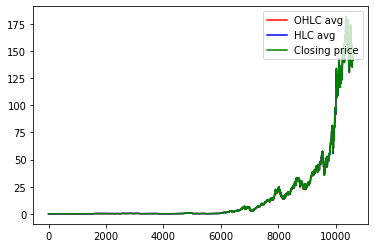

In [9]:
# 그래프로 각 지표들을 표시
plt.plot(obs, OHLC_avg, 'r', label = 'OHLC avg')
plt.plot(obs, HLC_avg, 'b', label = 'HLC avg')
plt.plot(obs, close_val, 'g', label = 'Closing price')
plt.legend(loc = 'upper right')
plt.show()

In [10]:
# 시계열 데이터로 준비
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg), 1))
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

In [11]:
# 데이터 셋을 훈련, 검증 셋으로 나눔.
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

# 시계열 데이터로 변경
train_x, train_y = new_dataset(train_OHLC, 1)
test_x, test_y = new_dataset(test_OHLC, 1)

# Reshaping
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))
step_size = 1

In [12]:
# 모델 생성, 객체로 생성하지 않음.
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

In [13]:
# 모델 컴파일, 모델 훈련
model.compile(loss='mean_squared_error', optimizer='adagrad')
model.fit(train_x, train_y, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
7941/7941 - 37s - loss: 3.7391e-04 - 37s/epoch - 5ms/step
Epoch 2/100
7941/7941 - 25s - loss: 3.7186e-04 - 25s/epoch - 3ms/step
Epoch 3/100
7941/7941 - 31s - loss: 3.7216e-04 - 31s/epoch - 4ms/step
Epoch 4/100
7941/7941 - 26s - loss: 3.7180e-04 - 26s/epoch - 3ms/step
Epoch 5/100
7941/7941 - 25s - loss: 3.7167e-04 - 25s/epoch - 3ms/step
Epoch 6/100
7941/7941 - 26s - loss: 3.7149e-04 - 26s/epoch - 3ms/step
Epoch 7/100
7941/7941 - 25s - loss: 3.7133e-04 - 25s/epoch - 3ms/step
Epoch 8/100
7941/7941 - 25s - loss: 3.7116e-04 - 25s/epoch - 3ms/step
Epoch 9/100
7941/7941 - 25s - loss: 3.7100e-04 - 25s/epoch - 3ms/step
Epoch 10/100
7941/7941 - 25s - loss: 3.7083e-04 - 25s/epoch - 3ms/step
Epoch 11/100
7941/7941 - 25s - loss: 3.7070e-04 - 25s/epoch - 3ms/step
Epoch 12/100
7941/7941 - 25s - loss: 3.7056e-04 - 25s/epoch - 3ms/step
Epoch 13/100
7941/7941 - 25s - loss: 3.7035e-04 - 25s/epoch - 3ms/step
Epoch 14/100
7941/7941 - 25s - loss: 3.7010e-04 - 25s/epoch - 3ms/step
Epoch 15/100
79

In [14]:
train_p = model.predict(train_x)
test_p = model.predict(test_x)

83/83 [==============================] - 0s 2ms/step


In [17]:
train_p = scaler.inverse_transform(train_p)
train_y = scaler.inverse_transform([train_y])

test_p = scaler.inverse_transform(test_p)
test_y = scaler.inverse_transform([test_y])

In [18]:
train_score = math.sqrt(mean_squared_error(train_y[0], train_p[:,0]))
print('Train RMSE: %.2f' % (train_score))

test_score = math.sqrt(mean_squared_error(test_y[0], test_p[:,0]))
print('Test RMSE: %.2f' % (test_score))

Train RMSE: 56965.06
Test RMSE: 73.89


In [19]:
train_p_plot = np.empty_like(OHLC_avg)
train_p_plot[:, :] = np.nan
train_p_plot[step_size : len(train_p)+step_size, :] = train_p

In [20]:
test_p_plot = np.empty_like(OHLC_avg)
test_p_plot[:, :] = np.nan
test_p_plot[len(train_p)+(step_size * 2)+1 : len(OHLC_avg)-1, :] = test_p

In [21]:
OHLC_avg = scaler.inverse_transform(OHLC_avg)

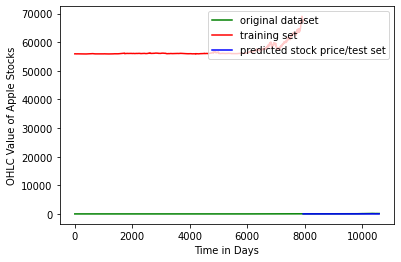

In [22]:
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(train_p_plot, 'r', label = 'training set')
plt.plot(test_p_plot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of Apple Stocks')
plt.show()

In [25]:
last_val = test_p[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print("Last Day Value:", np.asscalar(last_val))
print("Next Day Value:", np.asscalar(last_val*next_val))

1/1 [==============================] - 0s 15ms/step
Last Day Value: 4.234874248504639
Next Day Value: 0.11270114779472351


<ipython-input-25-26689ee40962>:4: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print("Last Day Value:", np.asscalar(last_val))
<ipython-input-25-26689ee40962>:5: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print("Next Day Value:", np.asscalar(last_val*next_val))
